# DDPLKO Moduł 11 - praca domowa - Optymalizacja modelu

To jedenasta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wykonanie optymalizacji jednego ze swoich modeli: modelu do klasyfikacji rysunków z QuickDraw, modelu wytrenowanego z wykorzystaniem transfer learningu, modelu do klasyfikacji binarnej
- [ ] Możesz wykorzystać pruning lub kwantyzację
- [ ] Porównaj Validation accuracy przed i po optymalizaji
- [ ] Porównaj wielkość zapisanych modeli - przed i po optymalizaji (rozmiar pliku zip z modelem)
- [ ] Udostępnij porównanie validation accuracy dla Twojego modelu przed i po optymalizacji wraz rozmiarami pliku zip na Discordzie `#klasyfikacja-wyniki`

Extra - dodatkowo możesz:
- Jeżeli masz kartę graficzną Nvidia'i, możesz spróbować wykorzystać TensorRT
- Wykonać wykres pruning-rate vs val-acc, by pokazać zależność Validation Accuracy od wartości pruningu (użyj early stoppingu w treningach)

# Zbiór danych

In [1]:
#!pip install tensorflow-model-optimization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
import os
import zipfile
import timeit
import time
from tqdm import tqdm

import tensorflow as tf
import tensorflow_model_optimization as tfmot

import tensorflow_datasets as tfds

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
(ds_train, ds_val),info = tfds.load(
    "stl10",
    split=["train[:80%]", "train[80%:100%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print('Train:',len(ds_train))
print('Val:',len(ds_val))

Train: 4000
Val: 1000


In [4]:
class_names = info.features['label'].names

num_classes = len(class_names)
num_classes

10

In [5]:
X_train = list(map (lambda x: x[0], ds_train))
X_train = np.asarray(X_train)
#X_train.shape

X_val = list(map (lambda x: x[0], ds_val))
X_val = np.asarray(X_val)
#X_val.shape

y_train = ds_train.map(lambda image, label: (image, label))
y_train = list(map (lambda x: [x[1]], y_train))
y_train = np.asarray(y_train)
#y_train.shape

y_val = ds_val.map(lambda image, label: (image, label))
y_val = list(map (lambda x: [x[1]], y_val))
y_val = np.asarray(y_val)
#y_val.shape

# Model

In [6]:
epochs = 50
batch_size = 64


In [7]:
model_baseline = tf.keras.Sequential([tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(96,96,3)),
                                      tf.keras.layers.AvgPool2D(),
                                      tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
                                      tf.keras.layers.AvgPool2D(),
                                      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                                      tf.keras.layers.AvgPool2D(),
                                      tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
                                      tf.keras.layers.GlobalAveragePooling2D(),
                                      tf.keras.layers.Dense(10, activation='softmax')])

model_baseline.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [8]:
history_baseline = model_baseline.fit(X_train, y_train,
                                     batch_size=batch_size,epochs=epochs,
                                     validation_data=(X_val, y_val),
                                     verbose=1)
                               

Epoch 1/50
63/63 [==============================] - 8s 115ms/step - loss: 2.9104 - accuracy: 0.1800 - val_loss: 1.9438 - val_accuracy: 0.2620
Epoch 2/50
63/63 [==============================] - 7s 113ms/step - loss: 1.7545 - accuracy: 0.3257 - val_loss: 1.7613 - val_accuracy: 0.3400
Epoch 3/50
63/63 [==============================] - 7s 114ms/step - loss: 1.6393 - accuracy: 0.3652 - val_loss: 1.6457 - val_accuracy: 0.3610
Epoch 4/50
63/63 [==============================] - 7s 113ms/step - loss: 1.6083 - accuracy: 0.3815 - val_loss: 1.6036 - val_accuracy: 0.4010
Epoch 5/50
63/63 [==============================] - 7s 114ms/step - loss: 1.5255 - accuracy: 0.4187 - val_loss: 1.5433 - val_accuracy: 0.3970
Epoch 6/50
63/63 [==============================] - 7s 114ms/step - loss: 1.4855 - accuracy: 0.4363 - val_loss: 1.5426 - val_accuracy: 0.4230
Epoch 7/50
63/63 [==============================] - 7s 114ms/step - loss: 1.4322 - accuracy: 0.4638 - val_loss: 1.4915 - val_accuracy: 0.4310
Epoch 

In [39]:
def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show();
    
    plt.figure(figsize=(15,7))
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show();

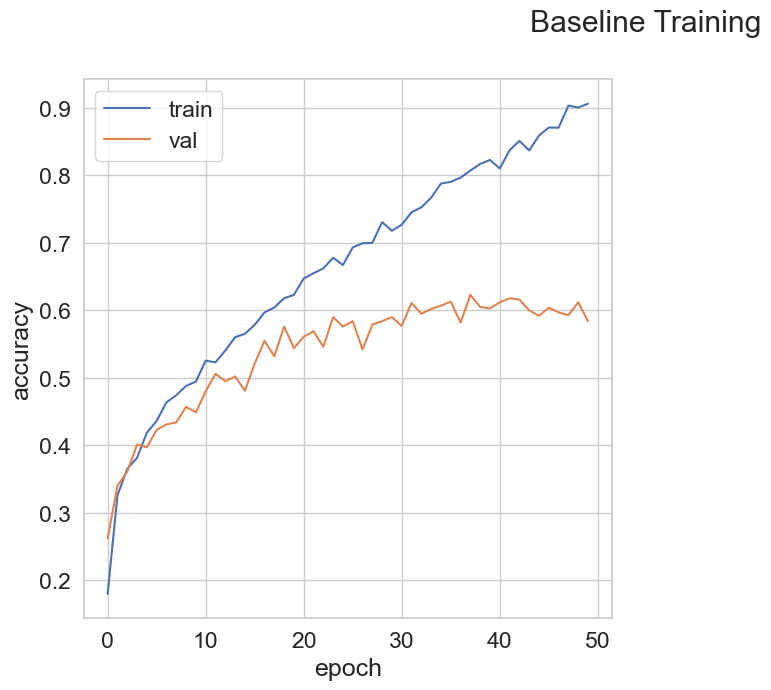

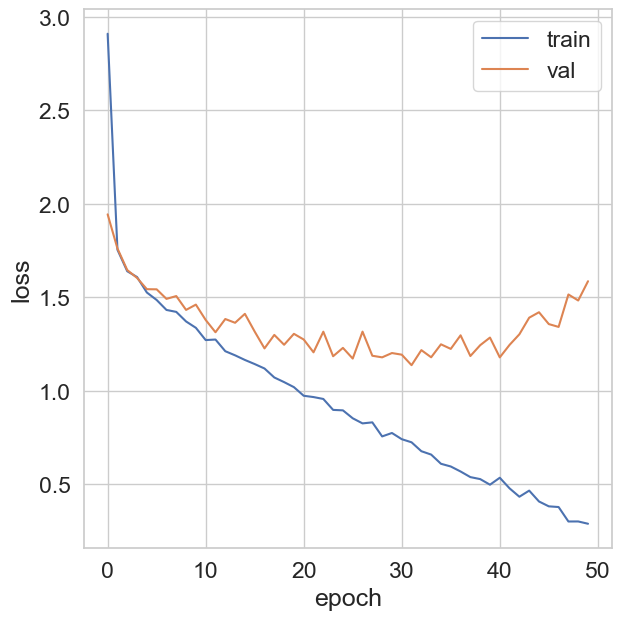

In [40]:
plot_history(history_baseline, 'Baseline Training')

In [11]:
_, acc_baseline = model_baseline.evaluate(X_val, y_val, verbose=1)
print('Baseline test accuracy:', acc_baseline)

32/32 [==============================] - 1s 18ms/step - loss: 1.5859 - accuracy: 0.5840
Baseline test accuracy: 0.5839999914169312


In [12]:
model_baseline.weights[0]

<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 8) dtype=float32, numpy=
array([[[[-0.14123975,  0.10510172,  0.15333721, -0.04181367,
          -0.15441002, -0.28988844, -0.1598379 ,  0.0645969 ],
         [-0.19833903,  0.0727312 , -0.03941303,  0.26672408,
           0.2055508 , -0.10852512,  0.30947384, -0.12538238],
         [-0.23524457, -0.02892249, -0.26464847,  0.04332595,
          -0.01189713,  0.13167827, -0.23976028, -0.24361591]],

        [[ 0.06331635,  0.22263825, -0.30171874,  0.0214841 ,
          -0.11081494,  0.20387492, -0.04507642,  0.05111987],
         [-0.13433388, -0.17901187, -0.01756455,  0.19677566,
          -0.0228305 , -0.23758616,  0.27986115,  0.13045871],
         [-0.22847523, -0.08075247, -0.32101318, -0.10505405,
          -0.19905536, -0.27217677, -0.12980463,  0.07522696]],

        [[-0.15272565,  0.28021532,  0.01046443, -0.13221098,
          -0.17308733,  0.14425866,  0.02360146, -0.16158614],
         [-0.03656793,  0.03630894, -0.25470945, 

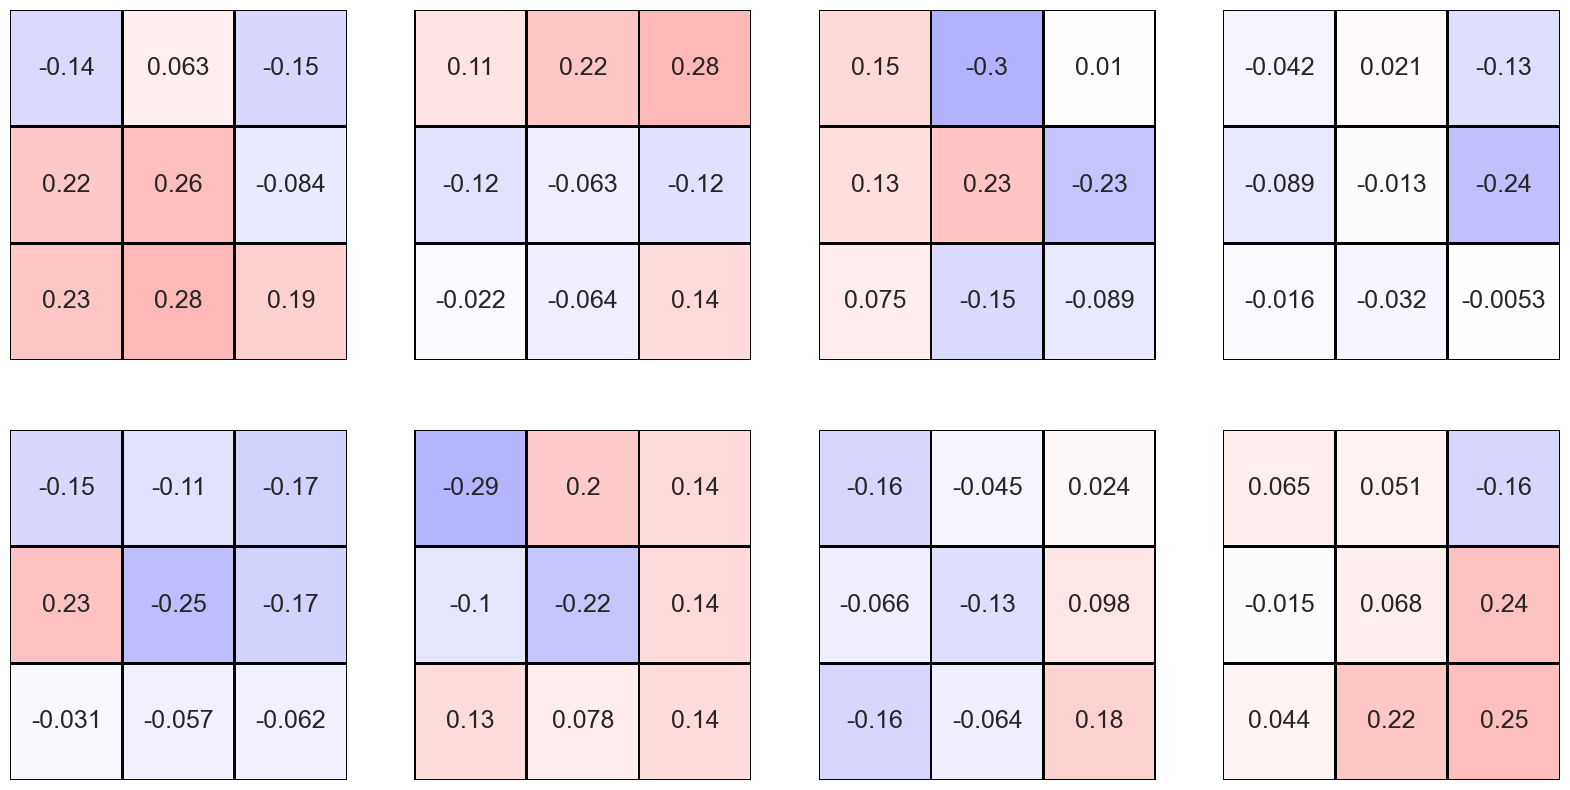

In [13]:
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

w = model_baseline.weights[0].numpy()[:,:,0,:]

plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2,4,1+i)
    sns.heatmap(w[:,:,i], cmap="bwr", annot=w[:,:,i],cbar=False,vmin=-1,vmax=1,linewidths=1,linecolor=(0,0,0))
    plt.xticks([])
    plt.yticks([])
plt.show();

In [14]:
tf.keras.models.save_model(model_baseline, 'model_baseline.h5', include_optimizer=False)

# Optymalizacja modelu

In [15]:
prune_epochs = 4
validation_split = 0.2
num_images = (X_train.shape[0] + X_val.shape[0]) * (1 - validation_split)

end_step = np.ceil(num_images / batch_size).astype(np.int32) * prune_epochs

In [16]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                           final_sparsity=0.80,
                                                                           begin_step=0,
                                                                           end_step=end_step,
                                                                           frequency=100)}

model_prune = prune_low_magnitude(model_baseline, **pruning_params)
model_prune.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [17]:
model_prune.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 96, 96, 8)         442       
_________________________________________________________________
prune_low_magnitude_average_ (None, 48, 48, 8)         1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 48, 48, 32)        4642      
_________________________________________________________________
prune_low_magnitude_average_ (None, 24, 24, 32)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 24, 24, 64)        36930     
_________________________________________________________________
prune_low_magnitude_average_ (None, 12, 12, 64)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_3 (None, 12, 12, 256)       2

In [18]:
callbacks = [tfmot.sparsity.keras.UpdatePruningStep(), # callback obowiązkowy podczas pruningu
             tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_summary')]

In [19]:
history_prune = model_prune.fit(X_train, y_train,
                                batch_size=batch_size,
                                epochs=prune_epochs,
                                #validation_split=validation_split,
                                validation_data=(X_val, y_val),
                                callbacks=callbacks)

Epoch 1/4
63/63 [==============================] - 10s 132ms/step - loss: 0.3277 - accuracy: 0.8903 - val_loss: 1.5059 - val_accuracy: 0.6170
Epoch 2/4
63/63 [==============================] - 7s 115ms/step - loss: 7.3604 - accuracy: 0.5785 - val_loss: 3.3985 - val_accuracy: 0.1850
Epoch 3/4
63/63 [==============================] - 7s 114ms/step - loss: 1.9492 - accuracy: 0.3158 - val_loss: 1.6797 - val_accuracy: 0.3500
Epoch 4/4
63/63 [==============================] - 7s 115ms/step - loss: 2.7268 - accuracy: 0.2842 - val_loss: 1.8498 - val_accuracy: 0.3290


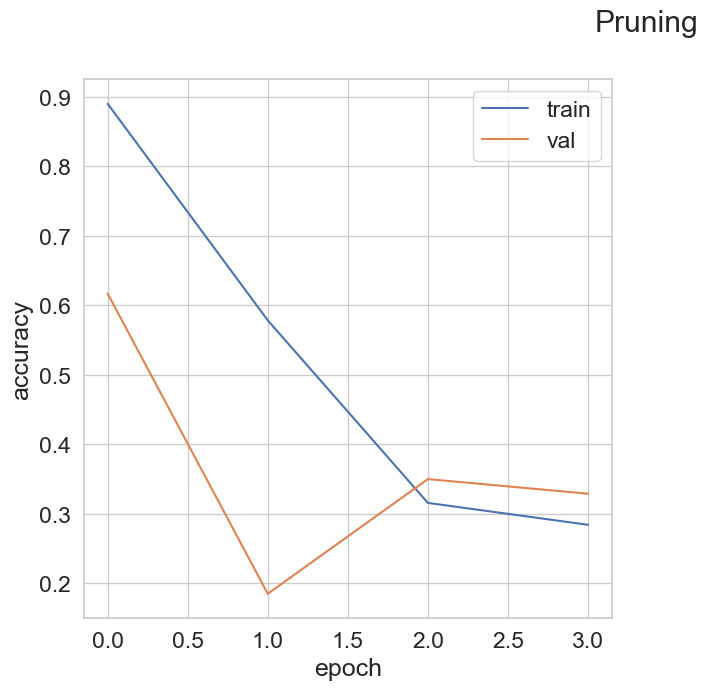

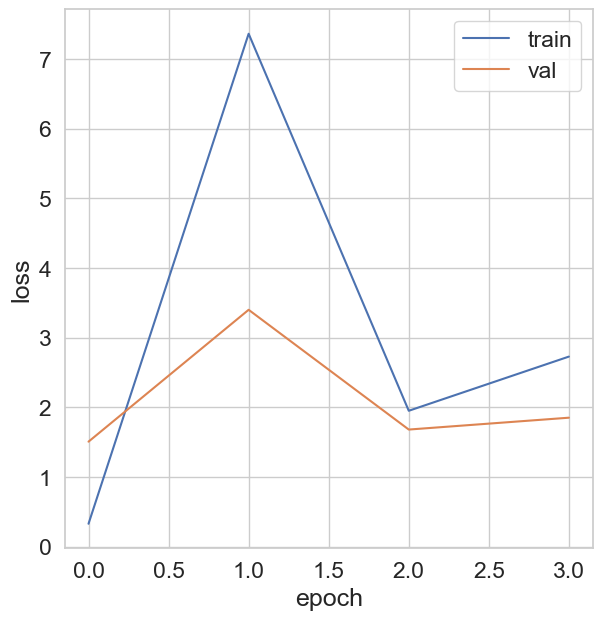

In [41]:
plot_history(history_prune, 'Pruning')
plt.show();

In [21]:
_, acc_prune = model_prune.evaluate(X_val, y_val, verbose=1)

32/32 [==============================] - 1s 19ms/step - loss: 1.8498 - accuracy: 0.3290


In [22]:
%load_ext tensorboard
%tensorboard --logdir prune_summary 

# Porównanie przed i po - Validation Accuracy

In [23]:
print('Baseline test accuracy:', acc_baseline)
print('Pruned test accuracy:', acc_prune)

Baseline test accuracy: 0.5839999914169312
Pruned test accuracy: 0.32899999618530273


In [24]:
model_prune.weights[0]

<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 8) dtype=float32, numpy=
array([[[[ 0.        ,  0.        , -0.        ,  0.        ,
          -0.        , -0.29499155, -0.        ,  0.        ],
         [ 0.        ,  0.        , -0.        ,  0.24851142,
          -0.        ,  0.        ,  0.27875018,  0.        ],
         [-0.26471895,  0.        , -0.27418563,  0.        ,
          -0.        ,  0.        , -0.2722788 , -0.24586806]],

        [[ 0.        ,  0.        , -0.31523225,  0.        ,
          -0.        , -0.        , -0.        ,  0.        ],
         [ 0.        ,  0.        , -0.        ,  0.        ,
          -0.        , -0.24262239,  0.24760897,  0.        ],
         [-0.2569955 ,  0.        , -0.33127907,  0.        ,
          -0.        , -0.27604917,  0.        ,  0.        ]],

        [[ 0.        ,  0.24759956, -0.        ,  0.        ,
          -0.        ,  0.        , -0.        ,  0.        ],
         [ 0.        ,  0.        , -0.27086696, 

In [25]:
model_sparse = tfmot.sparsity.keras.strip_pruning(model_prune)

In [26]:
model_sparse.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 8)         224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        2336      
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       1

In [27]:
model_sparse.weights[0]

<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 8) dtype=float32, numpy=
array([[[[ 0.        ,  0.        , -0.        ,  0.        ,
          -0.        , -0.29499155, -0.        ,  0.        ],
         [ 0.        ,  0.        , -0.        ,  0.24851142,
          -0.        ,  0.        ,  0.27875018,  0.        ],
         [-0.26471895,  0.        , -0.27418563,  0.        ,
          -0.        ,  0.        , -0.2722788 , -0.24586806]],

        [[ 0.        ,  0.        , -0.31523225,  0.        ,
          -0.        , -0.        , -0.        ,  0.        ],
         [ 0.        ,  0.        , -0.        ,  0.        ,
          -0.        , -0.24262239,  0.24760897,  0.        ],
         [-0.2569955 ,  0.        , -0.33127907,  0.        ,
          -0.        , -0.27604917,  0.        ,  0.        ]],

        [[ 0.        ,  0.24759956, -0.        ,  0.        ,
          -0.        ,  0.        , -0.        ,  0.        ],
         [ 0.        ,  0.        , -0.27086696, 

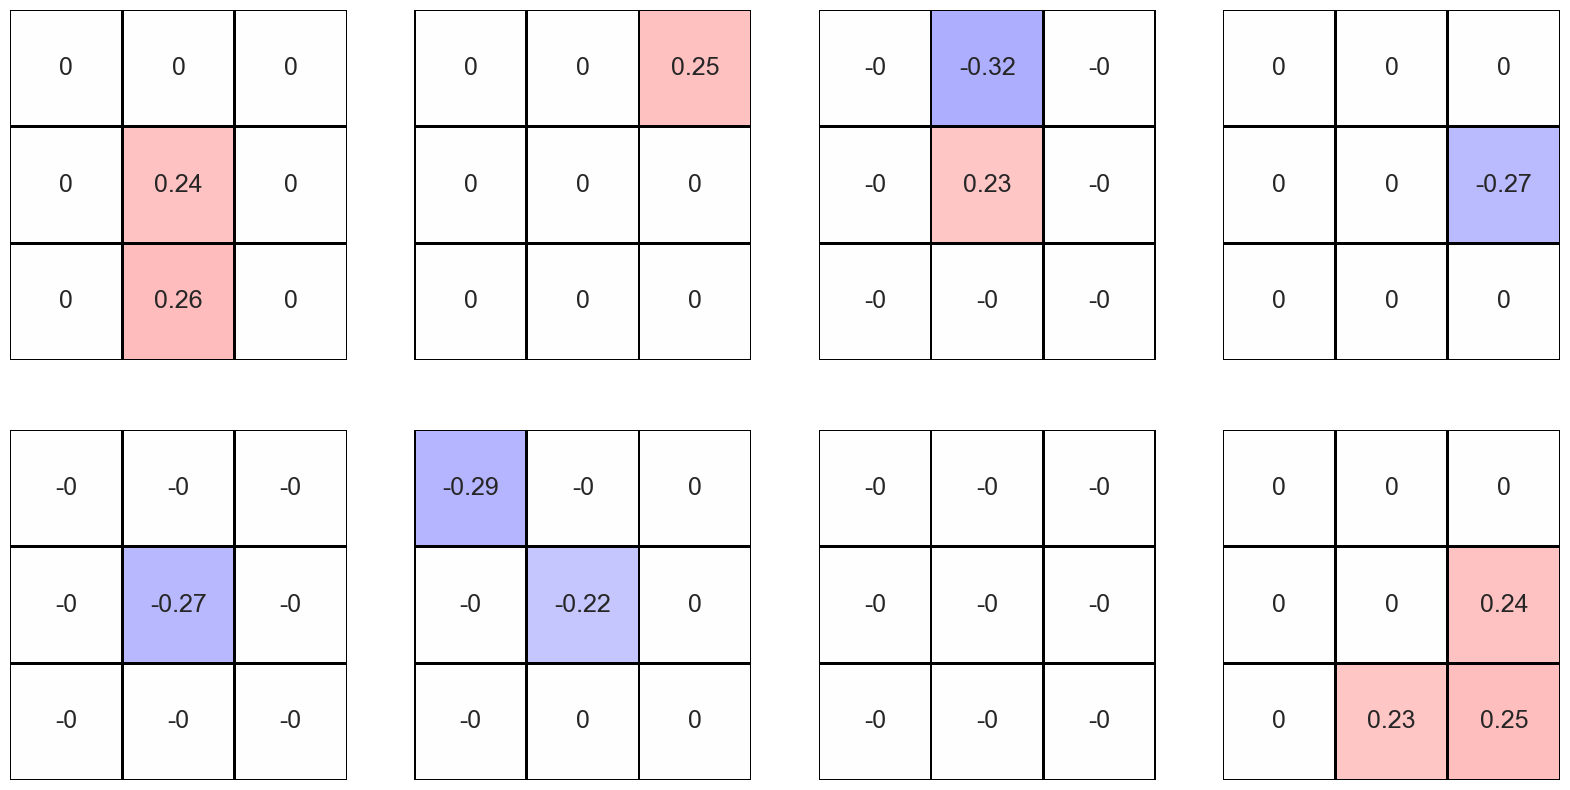

In [28]:
w = model_sparse.weights[0].numpy()[:,:,0,:]

plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2,4,1+i)
    sns.heatmap(w[:,:,i], cmap="bwr", annot=w[:,:,i],cbar=False,vmin=-1,vmax=1,linewidths=1,linecolor=(0,0,0))
    plt.xticks([])
    plt.yticks([])
plt.show();

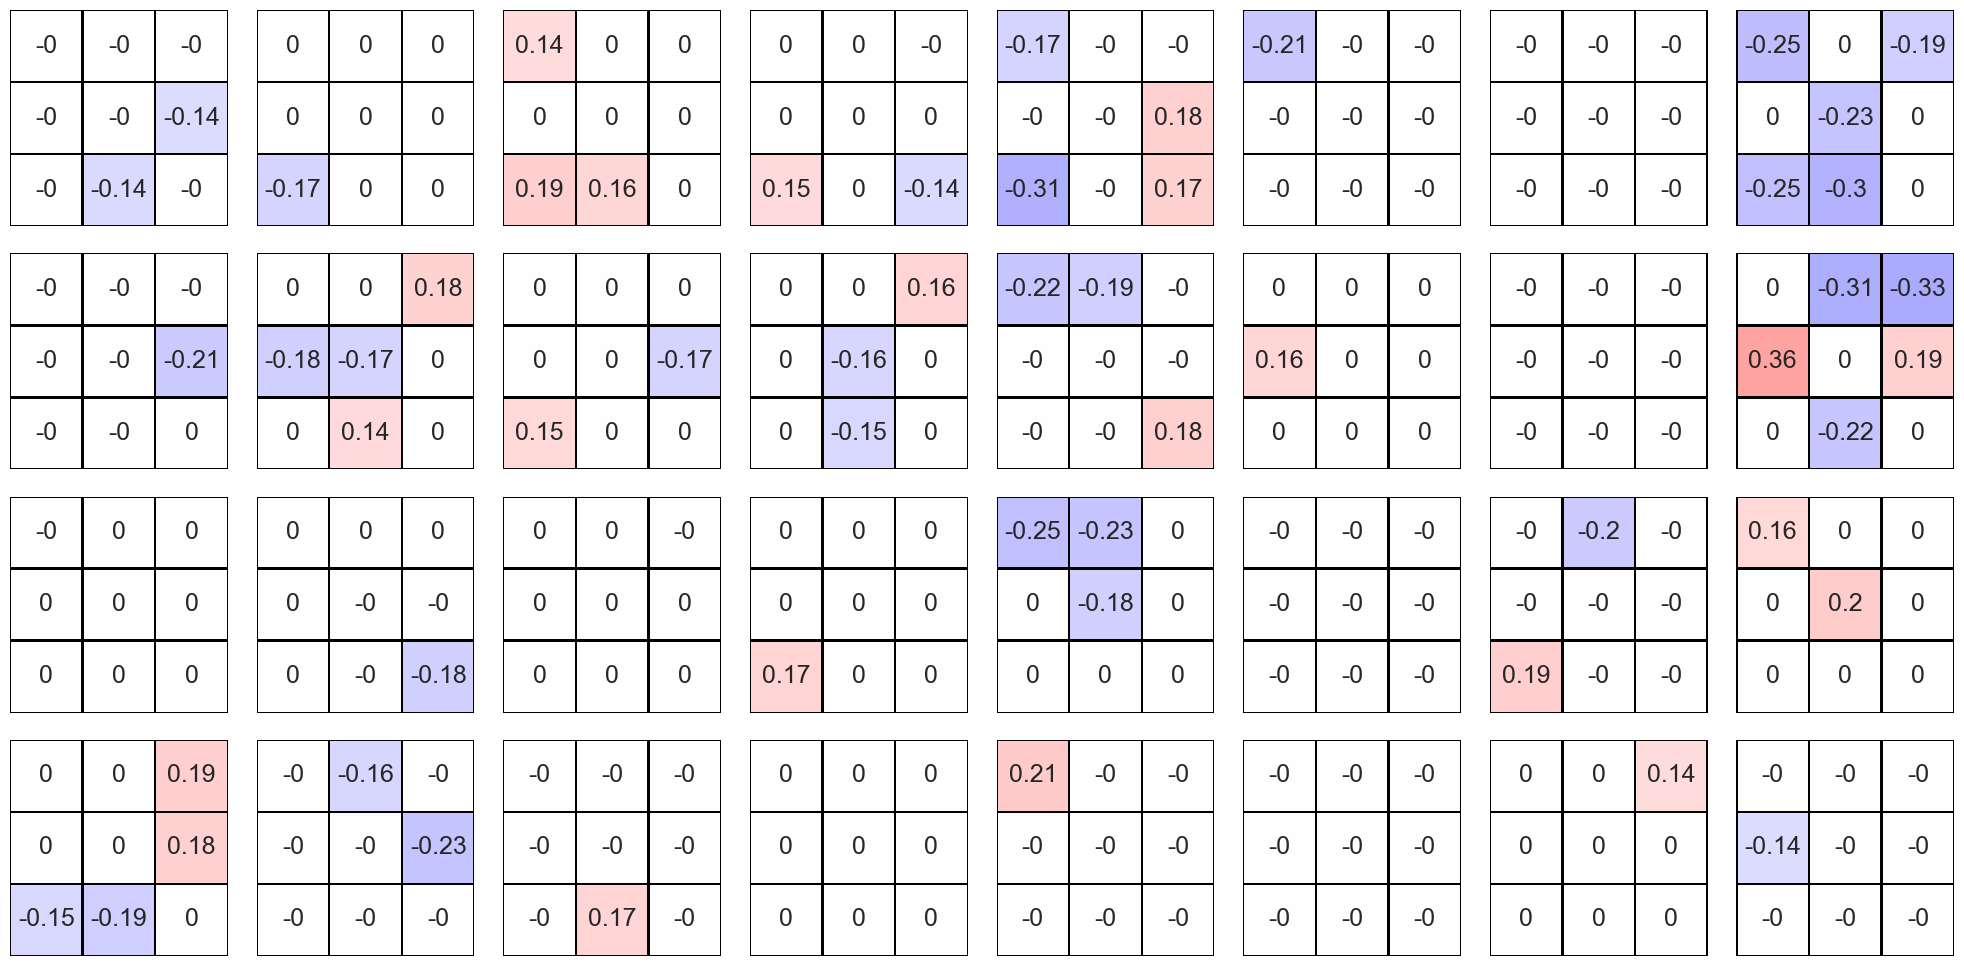

In [29]:
w = model_sparse.weights[2].numpy()[:,:,0,:]
plt.figure(figsize=(20,10))
for i in range(32):
    plt.subplot(4,8,1+i)
    sns.heatmap(w[:,:,i], cmap="bwr", annot=w[:,:,i],cbar=False,vmin=-1,vmax=1,linewidths=1,linecolor=(0,0,0))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

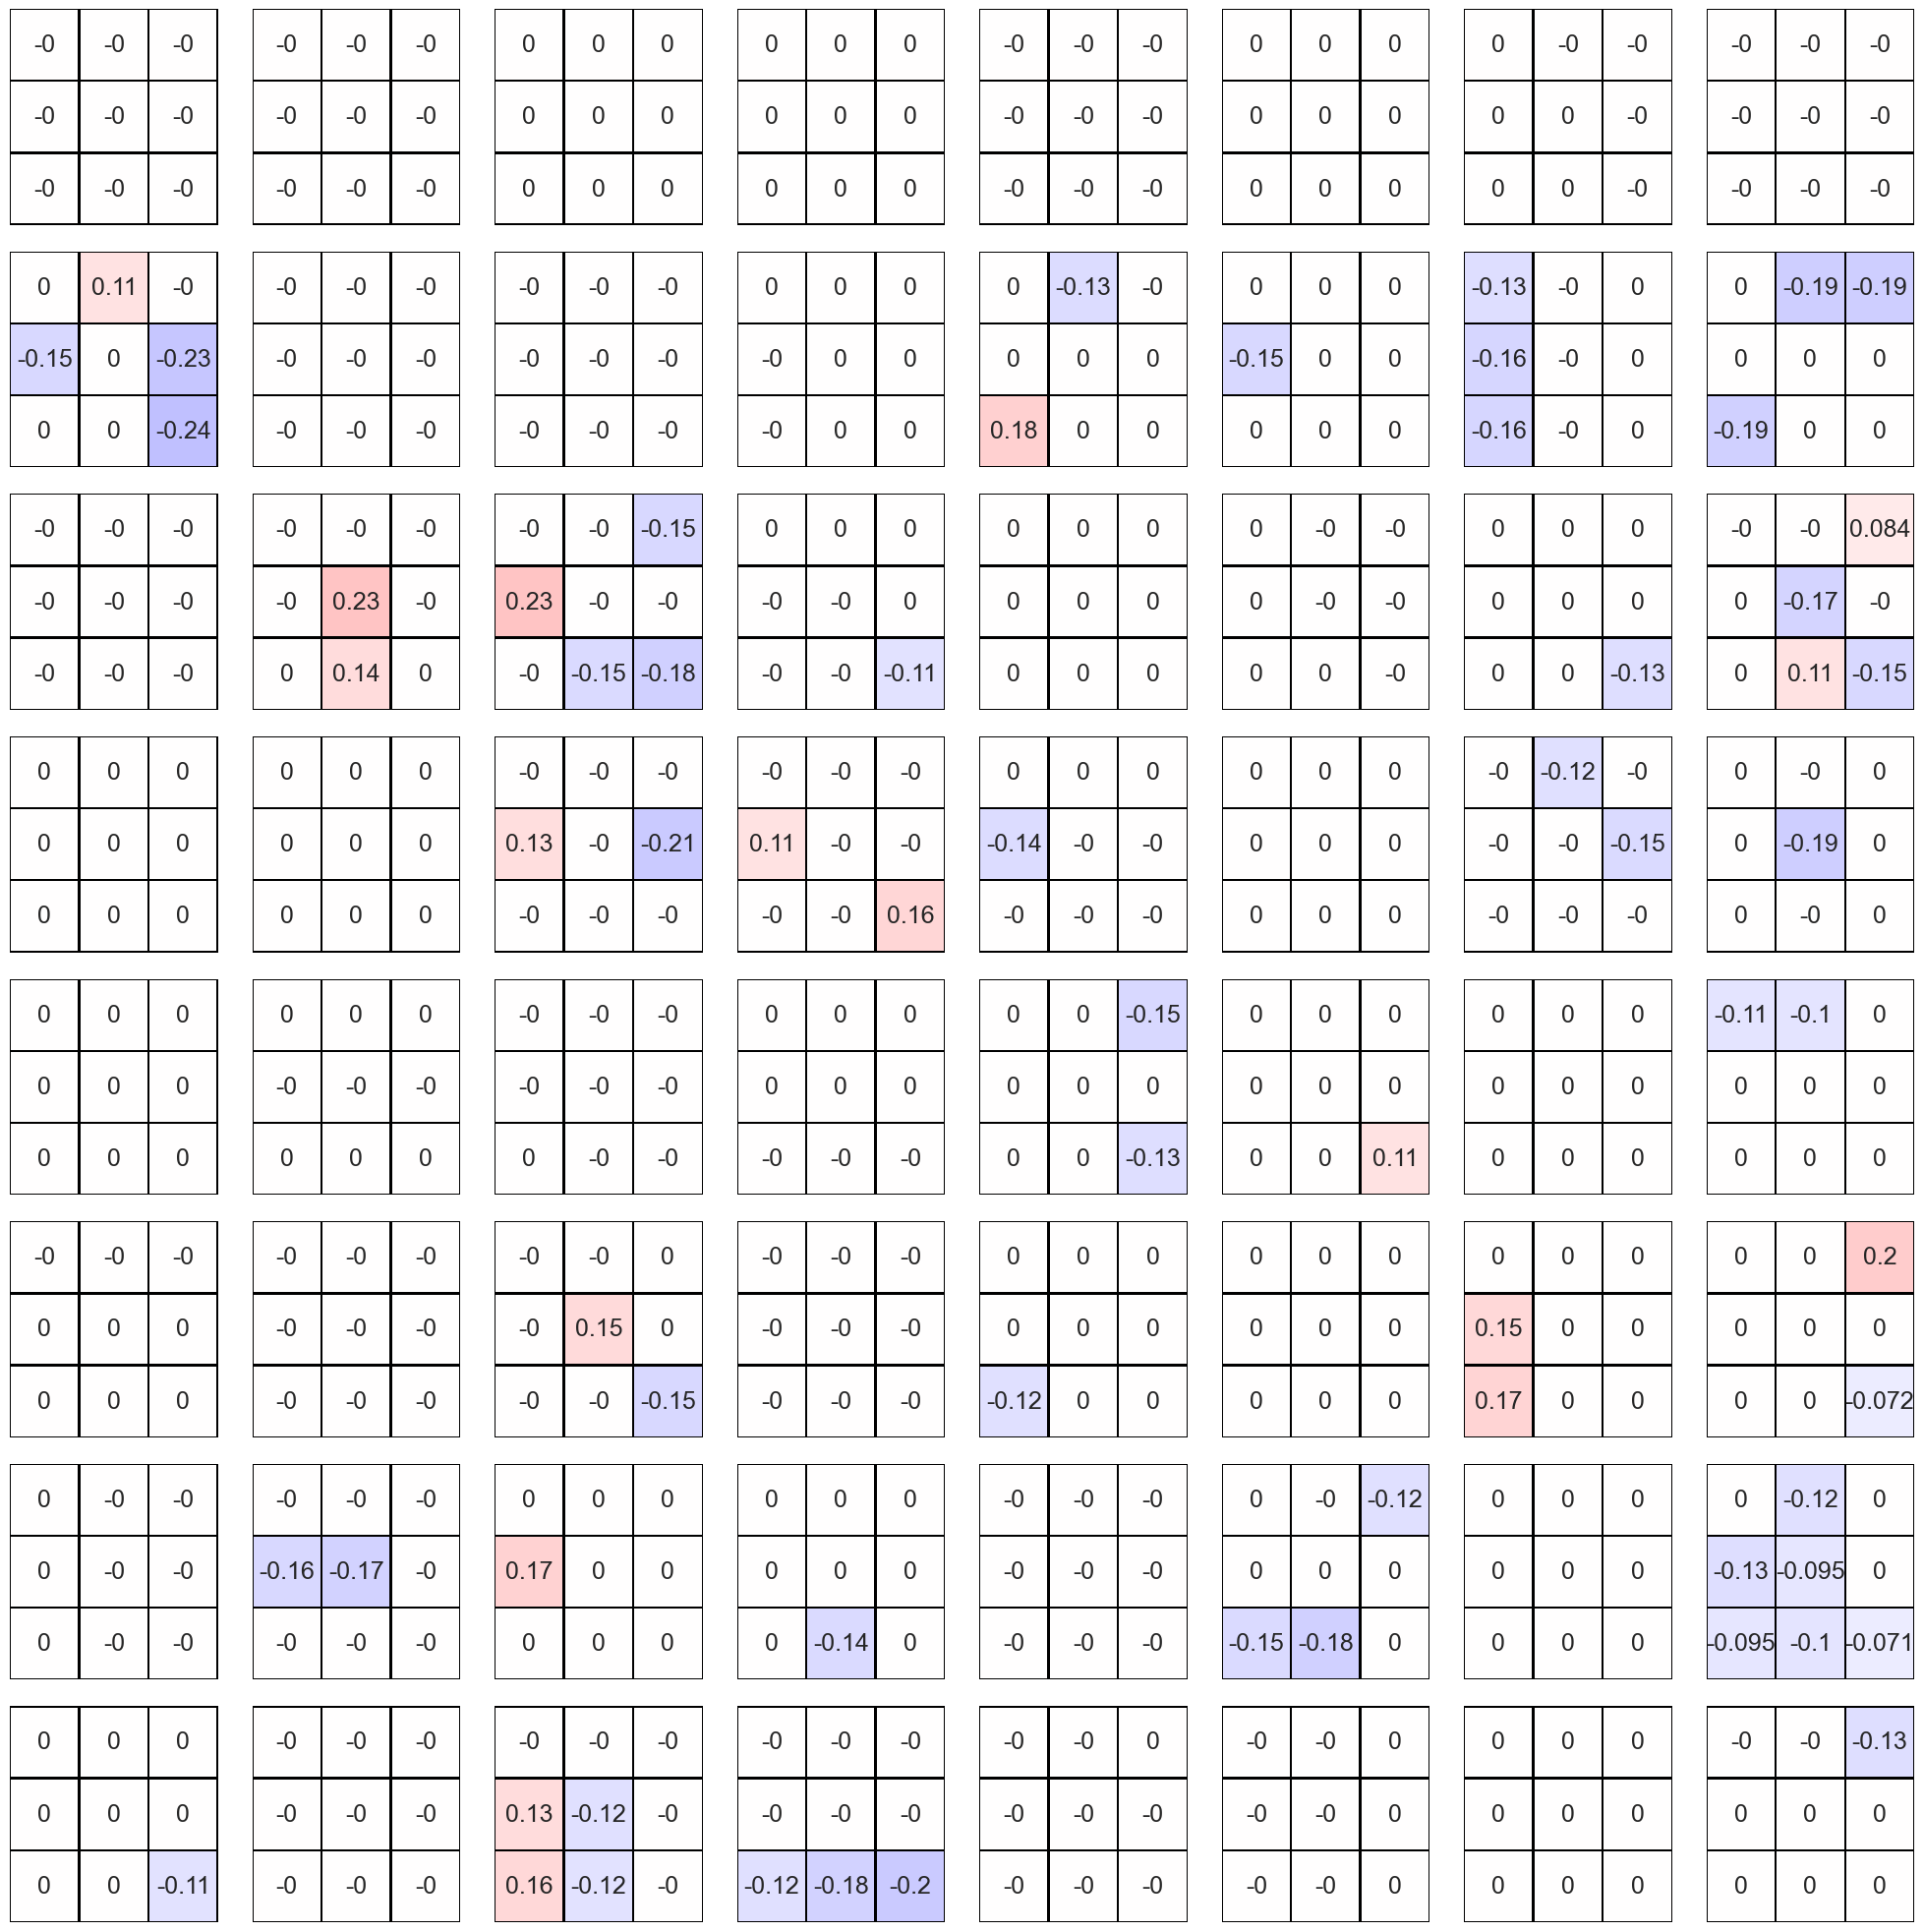

In [30]:
w = model_sparse.weights[4].numpy()[:,:,0,:]
plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,1+i)
    sns.heatmap(w[:,:,i], cmap="bwr", annot=w[:,:,i],cbar=False,vmin=-1,vmax=1,linewidths=1,linecolor=(0,0,0))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

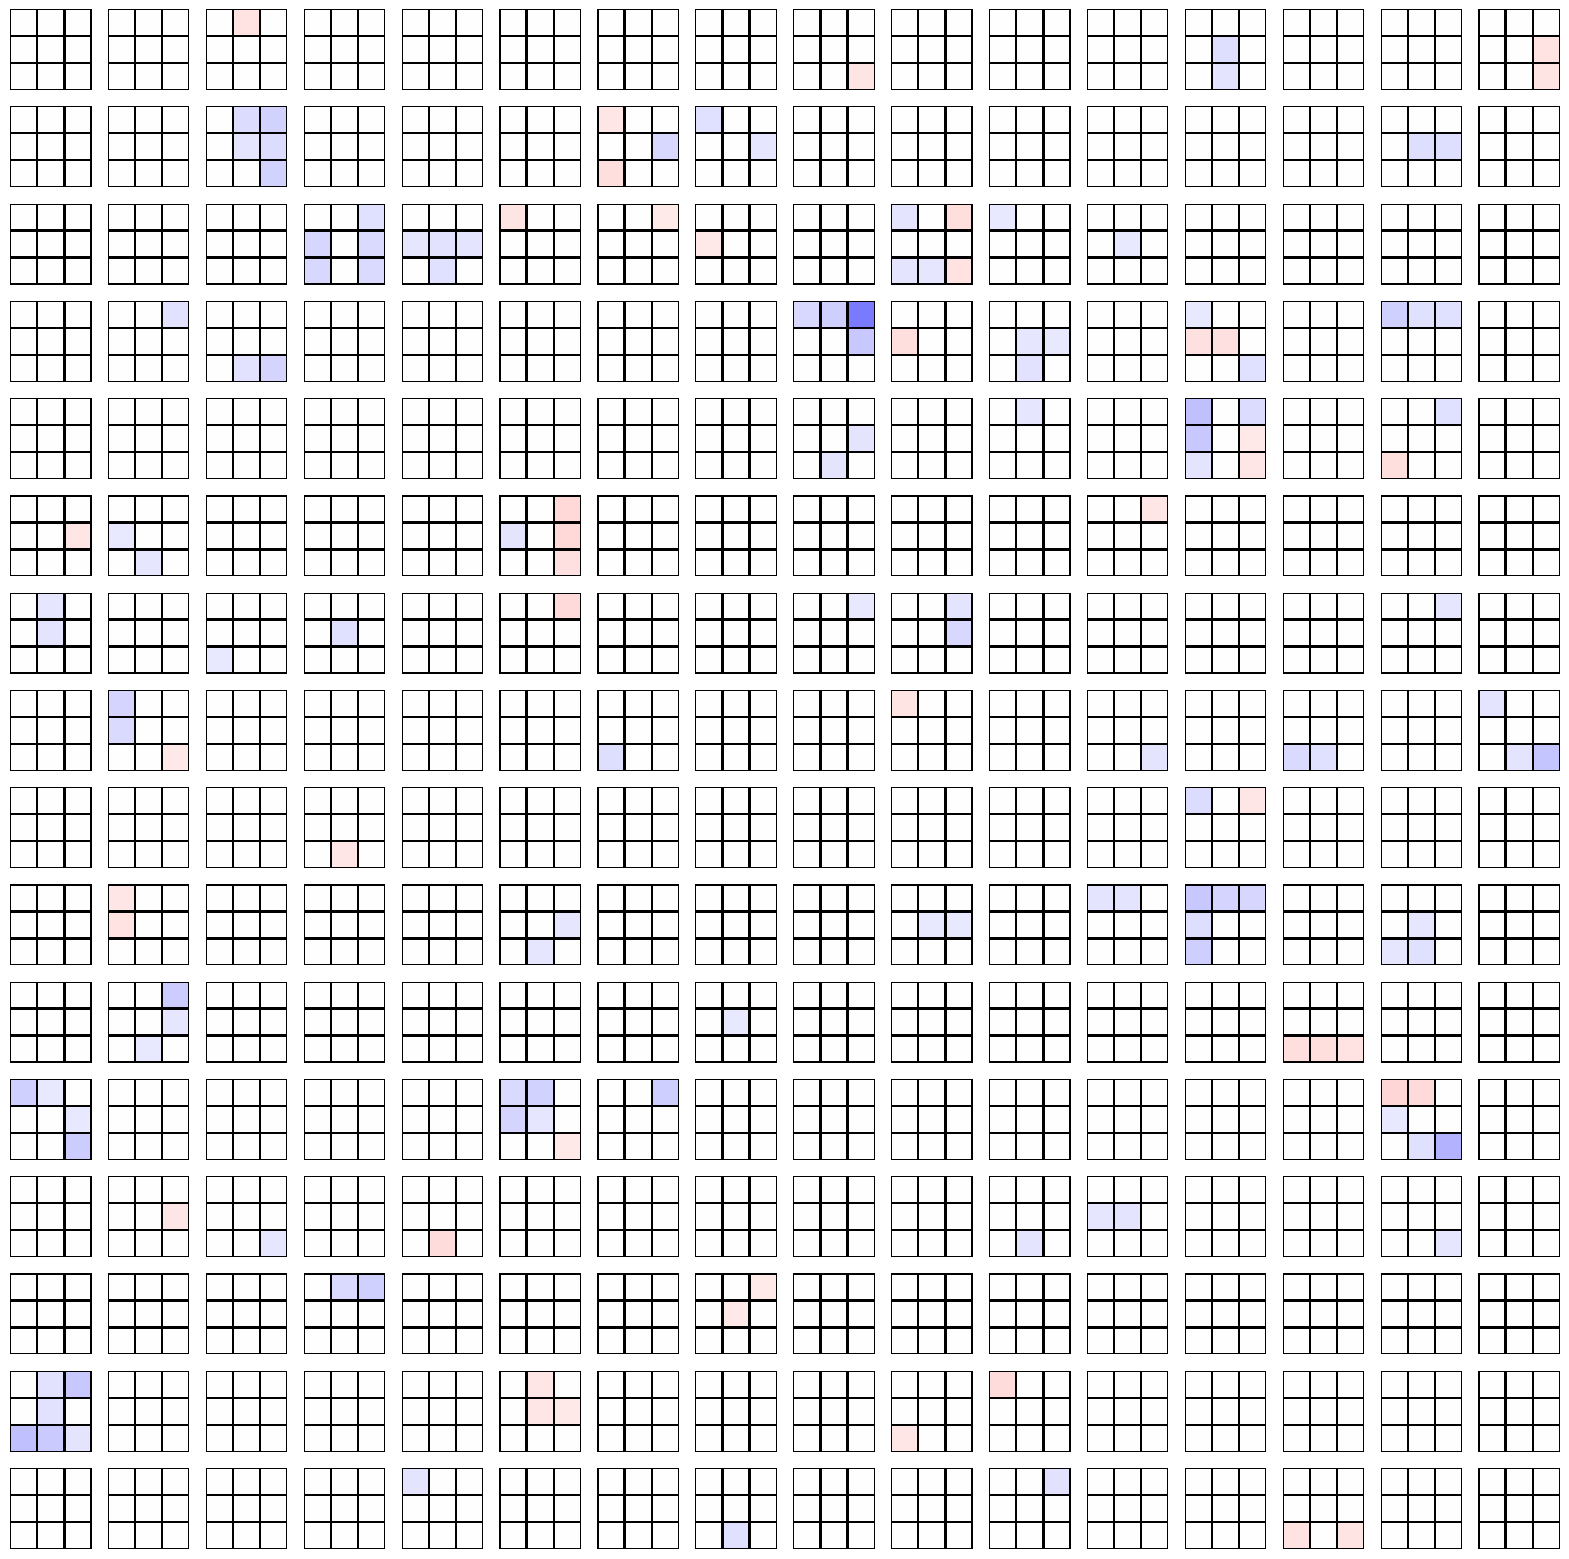

In [31]:
w = model_sparse.weights[6].numpy()[:,:,0,:]
plt.figure(figsize=(20,20))
for i in range(256):
    plt.subplot(16,16,1+i)
    sns.heatmap(w[:,:,i], cmap="bwr",
#                 annot=w[:,:,i],
                cbar=False,vmin=-1,vmax=1,linewidths=1,linecolor=(0,0,0))
    plt.xticks([])
    plt.yticks([])
# plt.tight_layout()
plt.show();

In [32]:
names = [model_sparse.weights[i].name for i in range(len(model_sparse.get_weights()))]
num_parameters = [weight.size for weight in model_sparse.get_weights()]
pruned = [np.sum(weight==0) / weight.size*100 for weight in model_sparse.get_weights()]

pd.DataFrame({'name': names, '# of parameters': num_parameters, '% pruned': pruned})

,name,# of parameters,% pruned
0,conv2d/kernel:0,216,79.629630
1,conv2d/bias:0,8,0.000000
2,conv2d_1/kernel:0,2304,79.730903
3,conv2d_1/bias:0,32,0.000000
4,conv2d_2/kernel:0,18432,79.736328
5,conv2d_2/bias:0,64,0.000000
6,conv2d_3/kernel:0,147456,79.736328
7,conv2d_3/bias:0,256,0.000000
8,dense/kernel:0,2560,79.726562
9,dense/bias:0,10,0.000000


In [33]:
print('Final sparsity: {}%'.format(pruning_params['pruning_schedule'].final_sparsity *100))

Final sparsity: 80.0%


In [34]:
tf.keras.models.save_model(model_sparse, 'model_sparse.h5', include_optimizer=False)

# Porównanie przed i po - Model size

In [35]:
print('h5 model files size:\n')
print('Baseline: {} bytes'.format(os.path.getsize('model_baseline.h5')))
print('Sparse:   {} bytes'.format(os.path.getsize('model_sparse.h5')))

h5 model files size:

Baseline: 716008 bytes
Sparse:   716008 bytes


In [36]:
with zipfile.ZipFile('model_baseline.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_baseline.h5')
    
with zipfile.ZipFile('model_sparse.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_sparse.h5')

In [37]:
print('Zipped model files size:\n')
print('Baseline: {} bytes'.format(os.path.getsize('model_baseline.zip')))
print('Sparse:   {} bytes'.format(os.path.getsize('model_sparse.zip')))

Zipped model files size:

Baseline: 641758 bytes
Sparse:   208988 bytes


In [38]:
os.path.getsize('model_baseline.zip') / os.path.getsize('model_sparse.zip')

3.0707887534212492